In [3]:
import numpy as np
import pandas as pd
import mysql.connector 
import db_cred
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import datetime as dt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings 
warnings.filterwarnings('ignore')

In [4]:
print(tf.__version__)

2.11.0


# 1. Import data

In [5]:
host = db_cred.host
user = db_cred.user
passwd = db_cred.passwd

mydb = mysql.connector.connect(
     host=host, 
     user=user, 
     passwd=passwd)

cursor = mydb.cursor()

In [6]:
cursor.execute(
"""
select * 
from ps_import.full_info
;
"""
)

data = pd.DataFrame(cursor.fetchall())
data.columns = ['stop_id', 'pid', 'exp_years', 'date_stop', 'time_stop', 'stop_dur', 
                'assignment_key', 'assignment', 'beat', 'beat_name','perceived_age','race', 'gender']

In [7]:
print('Null values: ',data.isna().sum().sum())
print('Duplicates: ', data.duplicated().sum())
data = data.drop_duplicates()

Null values:  0
Duplicates:  2


# 2. EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638104 entries, 0 to 638105
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype          
---  ------          --------------   -----          
 0   stop_id         638104 non-null  int64          
 1   pid             638104 non-null  int64          
 2   exp_years       638104 non-null  int64          
 3   date_stop       638104 non-null  object         
 4   time_stop       638104 non-null  timedelta64[ns]
 5   stop_dur        638104 non-null  int64          
 6   assignment_key  638104 non-null  int64          
 7   assignment      638104 non-null  object         
 8   beat            638104 non-null  object         
 9   beat_name       638104 non-null  object         
 10  perceived_age   638104 non-null  int64          
 11  race            638104 non-null  object         
 12  gender          638104 non-null  object         
dtypes: int64(6), object(6), timedelta64[ns](1)
memory usage: 68.2+ MB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
stop_id,638104.0,288244.026761,163151.726144,2443.0,149692.75,290687.5,428750.25,570029.0
pid,638104.0,1.226487,1.051746,1.0,1.0,1.0,1.0,52.0
exp_years,638104.0,6.319128,7.149545,1.0,1.0,3.0,10.0,50.0
time_stop,638104,0 days 13:10:10.157153065,0 days 06:21:55.804793537,0 days 00:00:00,0 days 08:35:00,0 days 13:23:31,0 days 18:17:53,0 days 23:59:58
stop_dur,638104.0,28.658457,50.351442,1.0,10.0,15.0,30.0,1440.0
assignment_key,638104.0,1.414039,1.775643,1.0,1.0,1.0,1.0,10.0
perceived_age,638104.0,37.100366,13.400787,1.0,25.0,35.0,45.0,120.0


In [10]:
data.describe(include='object').T

,count,unique,top,freq
date_stop,638104,1553,2019-05-23,808
assignment,638104,10,"Patrol, traffic enforcement, field operations",595877
beat,638104,127,521,45633
beat_name,638104,128,East Village 521,45633
race,638104,7,White,261870
gender,638104,5,Male,464345


## 2.1 Personal EDA

Median perceived age:  35.0
St dev perceived age:  13.4


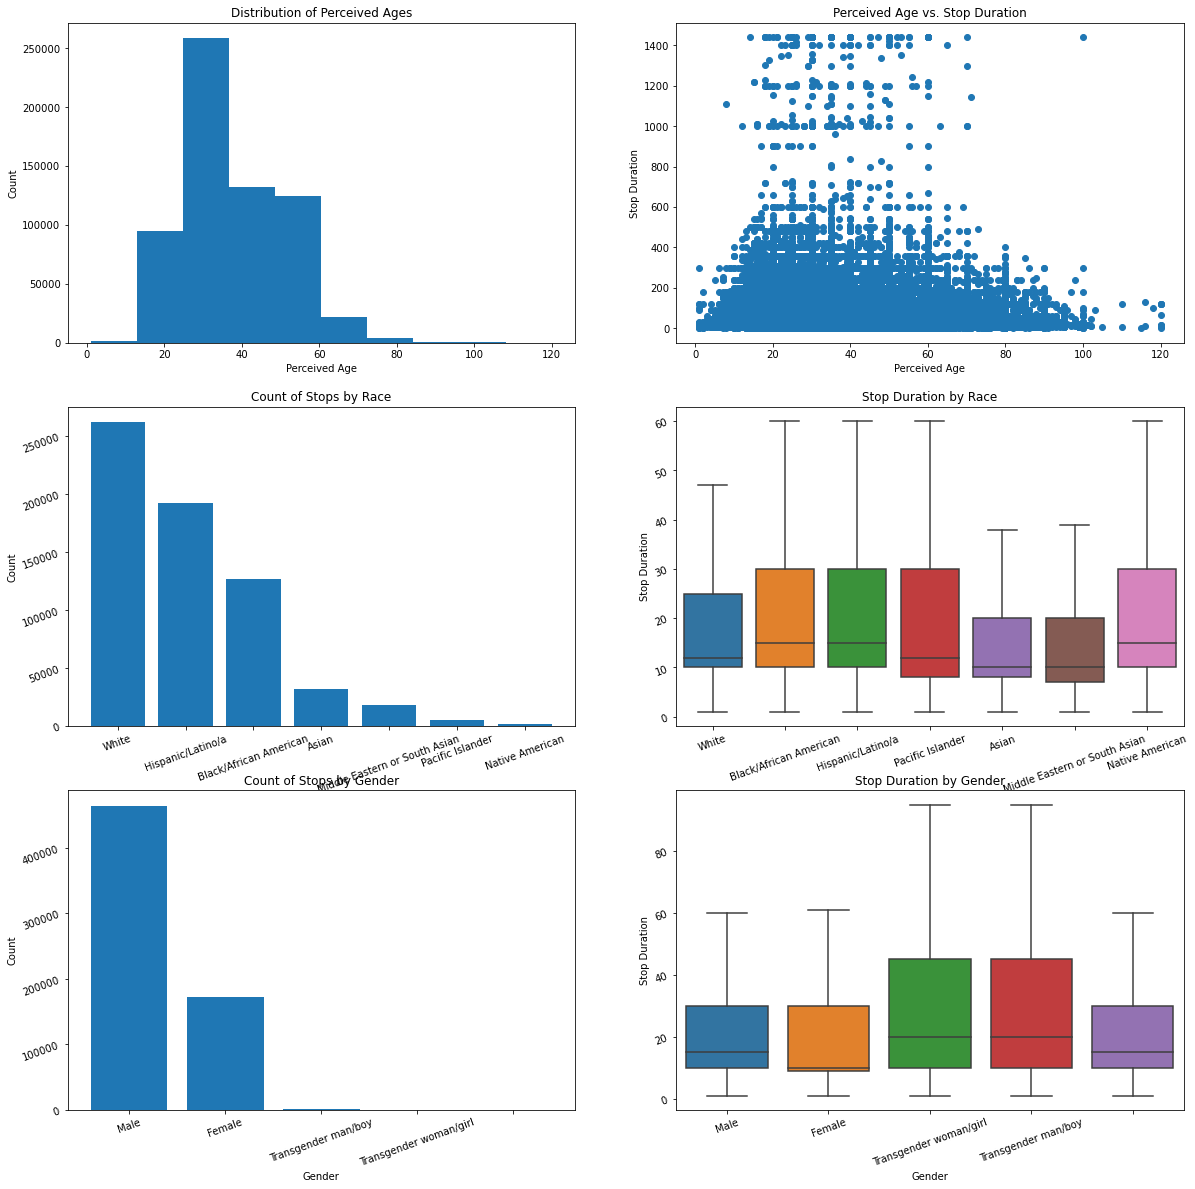

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

by_race = data.groupby('race').size().sort_values(ascending=False)
by_gend = data.groupby('gender').size().sort_values(ascending=False)

axs[0][0].hist(data.perceived_age)
axs[0][0].set_title('Distribution of Perceived Ages')
axs[0][0].set_xlabel('Perceived Age')
axs[0][0].set_ylabel('Count')

axs[0][1].scatter(data.perceived_age, data.stop_dur)
axs[0][1].set_title('Perceived Age vs. Stop Duration')
axs[0][1].set_xlabel('Perceived Age')
axs[0][1].set_ylabel('Stop Duration')

axs[1][0].bar(by_race.index, by_race.values)
axs[1][0].set_title('Count of Stops by Race')
axs[1][0].set_xlabel('Race')
axs[1][0].set_ylabel('Count')
axs[1][0].tick_params(labelrotation=20)

sns.boxplot(ax=axs[1][1], data=data, x='race', y='stop_dur', showfliers=False)
axs[1][1].set_title('Stop Duration by Race')
axs[1][1].set_xlabel('Race')
axs[1][1].set_ylabel('Stop Duration')
axs[1][1].tick_params(labelrotation=20)

axs[2][0].bar(by_gend.index, by_gend.values)
axs[2][0].set_title('Count of Stops by Gender')
axs[2][0].set_xlabel('Gender')
axs[2][0].set_ylabel('Count')
axs[2][0].tick_params(labelrotation=20)

sns.boxplot(ax=axs[2][1], data=data, x='gender', y='stop_dur', showfliers=False)
axs[2][1].set_title('Stop Duration by Gender')
axs[2][1].set_xlabel('Gender')
axs[2][1].set_ylabel('Stop Duration')
axs[2][1].tick_params(labelrotation=20)

print('Median perceived age: ', stats.median(data.perceived_age))
print('St dev perceived age: ', round(stats.stdev(data.perceived_age), 2))

In [12]:
by_race_avg = data.groupby('race').mean()['stop_dur'].sort_values(ascending=False)
by_gend_avg = data.groupby('gender').mean()['stop_dur'].sort_values(ascending=False)

print(by_race_avg)
print('')
print(by_gend_avg)

race
Native American                  33.221212
Black/African American           31.335454
Pacific Islander                 29.695038
Hispanic/Latino/a                29.170857
White                            28.050567
Asian                            23.666552
Middle Eastern or South Asian    21.462356
Name: stop_dur, dtype: float64

gender
Transgender woman/girl    39.368547
Transgender man/boy       38.772973
                          37.521552
Female                    28.961774
Male                      28.502465
Name: stop_dur, dtype: float64


**Age**: Age is approximately normal, centered around 35, with a standard deviation of 13.4. Can see that ages 18-70 tend to have the longest stop durations.
<br><br>
**Race**: Stop frequency of a certain race doesn't seem to correlate with stop duration. Stop frequency may be more related to population demographics. Natives Americans had the longerst average stop duration at 33.2 seconds, followed by Black/African Americans with 31.3 seconds.
<br><br>
**Gender**: Gender shows greater discrepancies than race. Transgender people tend to have significantly longer stop durations. Trans women have the longest average stop duration with 39.4 seconds, followed by trans men with 38.8 seconds. There is a signifcant drop off for cisgendered people with cis-females with an average of 29.0 seconds and cis-males with an average of 28.5 seconds. 

## 2.2 Officer EDA

In [13]:
officer_df = data[['stop_id','exp_years', 'assignment_key', 'assignment', 'beat_name', 'stop_dur']]
officer_df = officer_df.drop_duplicates()
officer_df.head()

,stop_id,exp_years,assignment_key,assignment,beat_name,stop_dur
0,10000,26,1,"Patrol, traffic enforcement, field operations",Kearney Mesa 313,5
1,100000,1,1,"Patrol, traffic enforcement, field operations",Hillcrest 627,10
3,100001,2,1,"Patrol, traffic enforcement, field operations",Chollas Creek 827,40
4,100002,1,1,"Patrol, traffic enforcement, field operations",Pacific Beach 122,10
5,100003,8,1,"Patrol, traffic enforcement, field operations",Rancho Bernardo 234,7


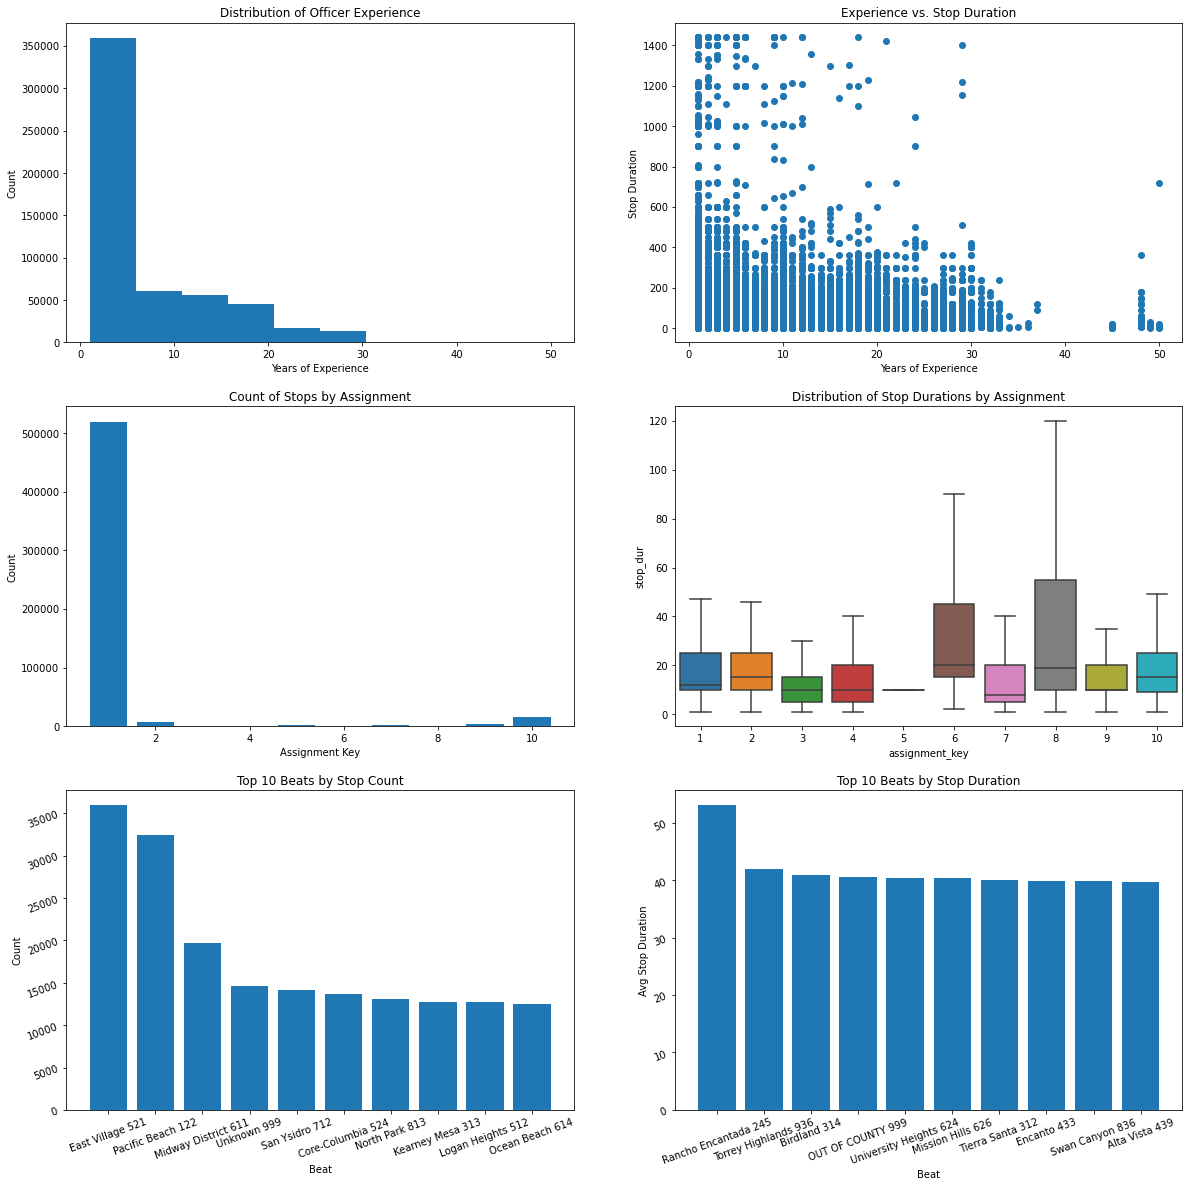

In [14]:
assignment = officer_df.groupby('assignment_key').size().sort_values(ascending=False)
beat = officer_df.groupby('beat_name').size().sort_values(ascending=False)
beat_avg = officer_df.groupby('beat_name').mean()['stop_dur'].sort_values(ascending=False)

fig, axs = plt.subplots(3, 2, figsize=(20,20))

axs[0][0].hist(officer_df.exp_years)
axs[0][0].set_title('Distribution of Officer Experience')
axs[0][0].set_xlabel('Years of Experience')
axs[0][0].set_ylabel('Count')

axs[0][1].scatter(officer_df.exp_years, officer_df.stop_dur)
axs[0][1].set_title('Experience vs. Stop Duration')
axs[0][1].set_xlabel('Years of Experience')
axs[0][1].set_ylabel('Stop Duration')

axs[1][0].bar(assignment.index, assignment.values)
axs[1][0].set_title('Count of Stops by Assignment')
axs[1][0].set_xlabel('Assignment Key')
axs[1][0].set_ylabel('Count')

sns.boxplot(ax=axs[1][1], data=officer_df, x='assignment_key', y='stop_dur', showfliers=False)
axs[1][1].set_title('Distribution of Stop Durations by Assignment')

axs[2][0].bar(beat.index[:10], beat.values[:10])
axs[2][0].set_title('Top 10 Beats by Stop Count')
axs[2][0].set_xlabel('Beat')
axs[2][0].set_ylabel('Count')
axs[2][0].tick_params(labelrotation=20)

axs[2][1].bar(beat_avg.index[:10], beat_avg.values[:10])
axs[2][1].set_title('Top 10 Beats by Stop Duration')
axs[2][1].set_xlabel('Beat')
axs[2][1].set_ylabel('Avg Stop Duration')
axs[2][1].tick_params(labelrotation=20)

In [15]:
officer_df.groupby(['assignment_key', 'assignment']).size()

assignment_key  assignment                                                                    
1               Patrol, traffic enforcement, field operations                                     519539
2               Gang enforcement                                                                    7437
3               Compliance check                                                                     397
4               Special events                                                                       984
5               Roadblock or DUI sobriety checkpoint                                                1859
6               Narcotics/vice                                                                       930
7               Task force                                                                          1850
8               K1-12 public school inlcuding school resource officer or school police officer       702
9               Investigative/detective                          

**Experience**: it seems that there is a higher density of less experienced officers making stops. Less experienced officers tend to make up the majority of longer stops, possibly due to lack of experience. As officers get more experienced, stop duration trends downward and varaiance of stop durations also decreases.
<br><br>
**Assignment**: Assignment 1 (Patrol, traffic enforcement, field operations) is what the vast majority of officers are assigned to when making arrests. This seems to be the main function of this assignment. The assignments with highest median stop durations were Narcotics/vice and K1-12 public school. It makes sense to have longer stop times in these assignments because both are areas where precaution should be taken. 
<br><br>
**Beat**: The top beats based on stop frequency and duration differ from each other. This suggests that there are certain areas where stops are more commonplace and routine, and others where stops are not as common, but are more serious.

## 2.3 Datetime EDA

In [16]:
datetime_df = data[['stop_id', 'pid','stop_dur']]
datetime_df['date_stop'] = data.date_stop.apply(lambda x: pd.to_datetime(x))
datetime_df['time_stop'] = data.time_stop.apply(lambda x: (dt.datetime.min+x).time())

datetime_df.head()

,stop_id,pid,stop_dur,date_stop,time_stop
0,10000,1,5,2018-07-15,19:31:37
1,100000,1,10,2019-02-03,09:00:47
2,100000,2,10,2019-02-03,09:00:47
3,100001,1,40,2019-02-03,08:02:21
4,100002,1,10,2019-02-03,09:03:05


In [17]:
datetime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638104 entries, 0 to 638105
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   stop_id    638104 non-null  int64         
 1   pid        638104 non-null  int64         
 2   stop_dur   638104 non-null  int64         
 3   date_stop  638104 non-null  datetime64[ns]
 4   time_stop  638104 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 45.3+ MB


In [18]:
years_dur = datetime_df.date_stop.apply(lambda x: x.year)
years_dur = pd.concat([years_dur, datetime_df.stop_dur], axis=1)
by_year = years_dur.groupby('date_stop')

In [19]:
month_dur = datetime_df.date_stop.apply(lambda x: x.month)
month_dur = pd.concat([month_dur, datetime_df.stop_dur], axis=1)
by_month = month_dur.groupby('date_stop')

In [20]:
weekday_dur = datetime_df.date_stop.apply(lambda x: x.weekday())
weekday_dur = pd.concat([weekday_dur, datetime_df.stop_dur], axis=1)
by_weekday = weekday_dur.groupby('date_stop')

In [21]:
hour_dur = datetime_df.time_stop.apply(lambda x: x.hour)
hour_dur = pd.concat([hour_dur, datetime_df.stop_dur], axis=1)
by_hour = hour_dur.groupby('time_stop')

Earliest data:  2018-07-01
Latest data:  2022-09-30


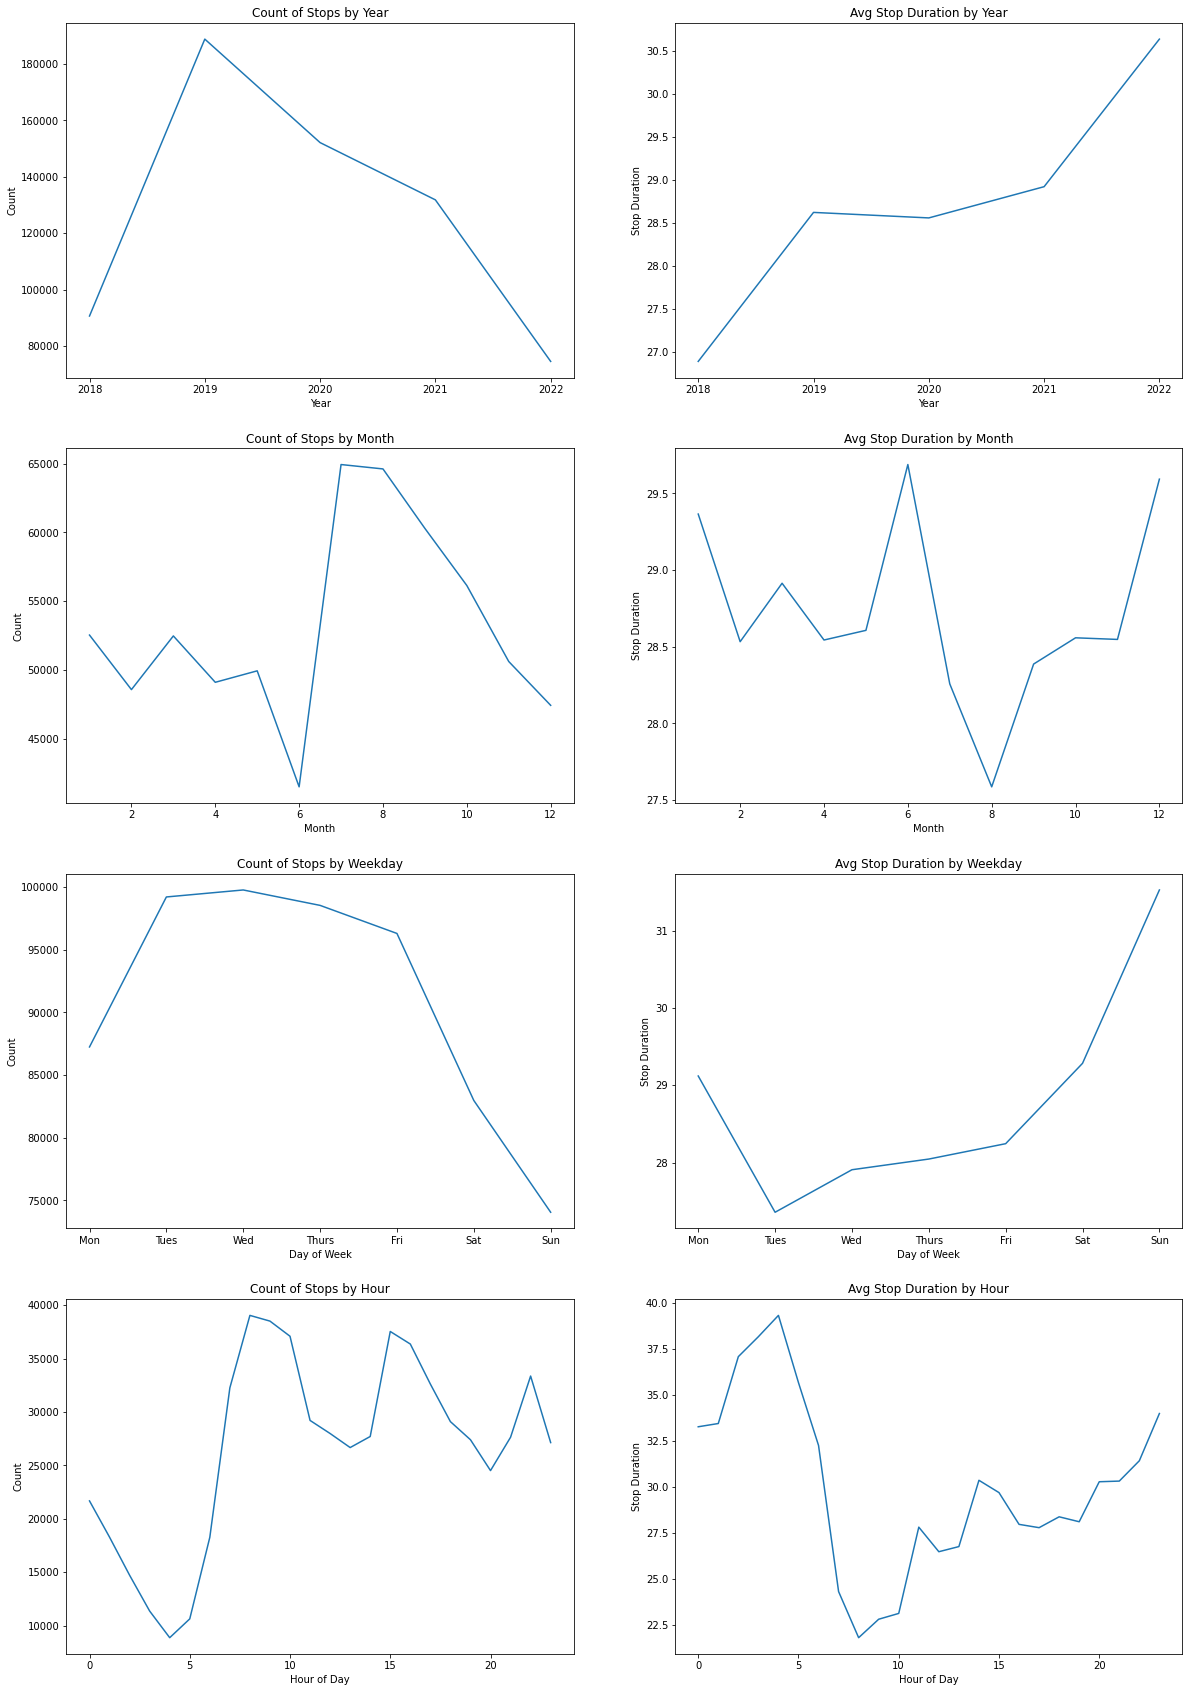

In [22]:
fig, axs =  plt.subplots(4, 2, figsize=(20,30))

## Year counts and avgs 
axs[0][0].plot(by_year.size().index, by_year.size().values)
axs[0][0].set_title('Count of Stops by Year')
axs[0][0].set_xlabel('Year')
axs[0][0].set_ylabel('Count')
axs[0][0].set_xticks(by_year.size().index)

axs[0][1].plot(by_year.mean().index, by_year.mean().values)
axs[0][1].set_title('Avg Stop Duration by Year')
axs[0][1].set_xlabel('Year')
axs[0][1].set_ylabel('Stop Duration')
axs[0][1].set_xticks(by_year.mean().index)

## Month counts and avgs
axs[1][0].plot(by_month.size().index, by_month.size().values)
axs[1][0].set_title('Count of Stops by Month')
axs[1][0].set_xlabel('Month')
axs[1][0].set_ylabel('Count')

axs[1][1].plot(by_month.mean().index, by_month.mean().values)
axs[1][1].set_title('Avg Stop Duration by Month')
axs[1][1].set_xlabel('Month')
axs[1][1].set_ylabel('Stop Duration')

## Weekday counts and avgs
axs[2][0].plot(by_weekday.size().index, by_weekday.size().values)
axs[2][0].set_title('Count of Stops by Weekday')
axs[2][0].set_xlabel('Day of Week')
axs[2][0].set_ylabel('Count')
axs[2][0].set_xticklabels(['','Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

axs[2][1].plot(by_weekday.mean().index, by_weekday.mean().values)
axs[2][1].set_title('Avg Stop Duration by Weekday')
axs[2][1].set_xlabel('Day of Week')
axs[2][1].set_ylabel('Stop Duration')
axs[2][1].set_xticklabels(['','Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

## Hour counts and avgs 
axs[3][0].plot(by_hour.size().index, by_hour.size().values)
axs[3][0].set_title('Count of Stops by Hour')
axs[3][0].set_xlabel('Hour of Day')
axs[3][0].set_ylabel('Count')

axs[3][1].plot(by_hour.mean().index, by_hour.mean().values)
axs[3][1].set_title('Avg Stop Duration by Hour')
axs[3][1].set_xlabel('Hour of Day')
axs[3][1].set_ylabel('Stop Duration')

print('Earliest data: ', min(data.date_stop))
print('Latest data: ', max(data.date_stop))

**Year**: Graph for count of stops by year is missing values because data collection began in July 2018, and the latest data is from September 2022, so we are missing significant amounts of data. However, we can see that average stop duration trends up over time.
<br><br>
**Month**: Graph for count of stops by month is missing values for same reason as above. We can see that stop durations in August seem to be the shortest, could be due to hot weather. We can also see that the longest stops occur in June, December, and January.
<br><br>
**Day of Week**: There are higher stop volumes for Tuesday-Friday, and then volume drop off for the weekend and then begins to rise again on Monday. Stop volume and stop duration seem to be inversely related as the stop duration for high volume days (Tues-Fri) is the lowest, with average stop duration increasing for Friday-Sunday, and decreasing again starting on Monday.
<br><br>
**Hour of Day**: We see the lowest stop volume from 12am-4am, then start to see a sharp increase until 8am. There are peaks from 8am-10am and 2pm-3pm. There is another spike at 10pm. These observations make sense as peaks occur at the beginning and end of typical work/school days. We see a similar inverse relationship between stop volume and stop duration. We see the longest stop durations from 12am-4am. Stop duration dramatically drops until 8am. There is then a stead increase in stop durations for the rest of the day.

# 3. Feature Selection
### Goal: Predict stop duration
**Personal**: Use all (perceived age, race, gender). Split gender into binary trans and cis
<br><br>
**Officer**: Use years of experience
<br><br>
**Datetime**: Use year, day of week, and time of day.

In [23]:
features = data[['exp_years', 'perceived_age', 'race', 'gender']]
features['year'] = data.date_stop.apply(lambda x: x.year)
features['weekday'] = data.date_stop.apply(lambda x: x.weekday())
features['hour'] = data.time_stop.apply(lambda x: (dt.datetime.min+x).time().hour)

target = data.stop_dur

features.head()

,exp_years,perceived_age,race,gender,year,weekday,hour
0,26,50,White,Male,2018,6,19
1,1,35,White,Male,2019,6,9
2,1,35,White,Male,2019,6,9
3,2,60,Black/African American,Male,2019,6,8
4,1,25,White,Female,2019,6,9


## 3.1 Scaling and encoding
**Scale**: exp_years, perceived_age (Not scaling weekday or hour because they are categorical encodings)
<br>
**Encode**: race, make gender binary for trans

In [24]:
features.head()

,exp_years,perceived_age,race,gender,year,weekday,hour
0,26,50,White,Male,2018,6,19
1,1,35,White,Male,2019,6,9
2,1,35,White,Male,2019,6,9
3,2,60,Black/African American,Male,2019,6,8
4,1,25,White,Female,2019,6,9


In [25]:
### Scaling
exp_mean = np.mean(features.exp_years)
exp_sd = stats.stdev(features.exp_years)
exp_scaled = (features.exp_years-exp_mean)/exp_sd

age_mean = np.mean(features.perceived_age)
age_sd = stats.stdev(features.perceived_age)
age_scaled = (features.perceived_age-age_mean)/age_sd

X = pd.DataFrame()

X['exp_years'] = exp_scaled
X['perceived_age'] = age_scaled

In [26]:
np.unique(features.gender)

array(['', 'Female', 'Male', 'Transgender man/boy',
       'Transgender woman/girl'], dtype=object)

In [27]:
### Encoding 
race_dummies = pd.get_dummies(features.race, drop_first=True)
gender_dummies = pd.get_dummies(features.gender, drop_first=True)

X = pd.concat([X, race_dummies, gender_dummies, features.iloc[:,-3:]], axis=1)
X['year'] = X['year'].apply(lambda x: x-2010)

In [28]:
X = X
y = target 
df = pd.concat([X,y], axis=1)

In [30]:
df.to_csv('model_features.csv') # for NN trial

KeyboardInterrupt: 

# 4. Train test split

In [26]:
X = X
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=72)